# Mental Health Status Prediction using NLP


### Objective:

Develop a machine learning model to classify text-based statements into seven mental health statuses (Normal, Depression, Suicidal, Anxiety, Stress, Bi-Polar, Personality Disorder) using Natural Language Processing (NLP) techniques.

### Key Goals:

- Predict mental health status based on textual data.
- Develop an explainable model to highlight key words or phrases influencing classification.
- Develop an AI-powered system.

### Dataset

Download the dataset [here](https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health#)


# Import Libraries

In [1]:
import os
import re
import pickle
import gensim
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder


import sys
sys.path.append("..")
from ml_helper.data_processing import (load_pickle, save_npz_file, load_npz_file,
                                       preprocess_text, stratified_train_val_test_split,
                                       process_data_for_model_input)
from ml_helper.data_ingestion import convert_non_strings_to_strings, validate_dataset
from ml_helper.data_visualization import plot_embeddings, plot_loss, plot_confmat


SEED = 6
np.random.seed(SEED)


import warnings  # noqa: E402
warnings.filterwarnings('ignore')

2025-02-19 05:09:42.697673: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package punkt to /Users/enge/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/enge/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Loading

In [2]:
# Set the display option to show the entire content of each column
pd.set_option('display.max_colwidth', None)

df = pd.read_csv("../data/combined Data.csv", index_col=0)
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless heart. All out of tune",Anxiety
2,"All wrong, back off dear, forward doubt. Stay in a restless and restless place",Anxiety
3,I've shifted my focus to something else but I'm still worried,Anxiety
4,"I'm restless and restless, it's been a month now, boy. What do you mean?",Anxiety


# Data Exploration

In [4]:
# Shape
print(f"The shape of the data is: {df.shape}")

The shape of the data is: (53043, 2)


In [5]:
# Null values
df.isna().sum()

statement    362
status         0
dtype: int64

In [6]:
# Duplicates
df.duplicated().sum()

1944

In [7]:
# Inspect all duplicate rows
df_duplicated = df[df.duplicated()]
df_duplicated.shape

(1944, 2)

In [8]:
df_duplicated

,statement,status
97,"""No regrets or grudges/angry at things that have passed, and not worrying too much about the future, that's true serenity.""",Anxiety
138,but my heart is still restless even though my mouth is talking,Anxiety
167,I want to exhale the restlessness in my chest with my breath,Anxiety
228,Do not compare yourself to others. Envy only makes restless soul. Be yourself.,Anxiety
244,"people seem calm, happy like there's no problem because only one smile we throw out but sad, restless and anxious millions of which we keep to ourselves, only we know.",Anxiety
...,...,...
53038,"Nobody takes me seriously I’ve (24M) dealt with depression/anxiety for years now. I used to be great with people, make good money, have the nice cars, great girlfriend, supportive parents, friends that I could say looked up to me etc. and then I was diagnosed with depression. Within about a year, I quit my job, lost my girlfriend even though she was great to me, and have yet to keep a stable job for more than a month at a time. \n\nMy depression eventually was ruled to be “treatment resistant” after being on a number of meds and trying many other things. Some would work for a couple months and then I’d fall even further back from where I was. \n\nBut now, after not having worked since early July of 2022, I am dealing with extensive and scary brain fog. I’ve incorporated working out, eating healthier, taking supplements and just trying to live a healthier lifestyle as I figured this was coming from a bad diet my whole life. I also got all blood work done including thyroid, basics, vitamin levels, testosterone etc and everything came back normal other than pretty high cholesterol. Both doctors I’ve seen (general practitioner, psychiatrist) has kinda blown me off when I tell them about the brain fog. Almost like they don’t really know what to say or what the next step should be to ruling out causes. \n\nI’m so scared as I’m feeling like I’m going crazy or have dementia. My parents are usually very supportive when I’m going through stuff but my mom doesn’t even want to hear me talk about it and my dad isn’t always around as he lives about 45 mins away. I ended up packing some things and driving to his house tonight without saying anything to my mom. I just hate feeling alone and don’t know what to do anymore. I feel like I’m at the end of my road",Anxiety
53039,"selfishness ""I don't feel very good, it's like I don't belong in this world (I don't think I ever did). My friends are happy, and I'm always the one who's not really funny and who ruins the mood. So now I try to say as little as possible, people always ask me if I'm okay, if I'm tired, or worse, they say I'm scary. I think I'm just a mistake. People must find me weird or creepy, it's ruining me. A few years ago, my brother committed suicide, I felt very close to him, I think about his death all the time, I wish I could start my life over again and make the right choices (for once). What affects me the most is girls, I think... It's ridiculous, but I would love to have a relationship with a (very) pretty girl. Sometimes I think I've suffered so much that I would at least deserve that. I saw the damage my brother's death caused in my family, now I think if I didn't have a family to make suffer =&gt; suicide. My message is so selfish, and I know it. Thank you for reading these few lines..."" \n\n\-Lust",Anxiety
53040,"Is there any way to sleep better? I can't sleep most of the nights, meds didn't help.",Anxiety
53041,"Public speaking tips? Hi, all. I have to give a presentation at work next week (45 minutes long and the CEO will be in attendance). I’m already panicking, as once the anxiety kicks in, I’m certain I’m going to forget everything I’m supposed to say. ( anxiety makes it very difficult for me to focus on anything) Does anyone have any speaking tips that have worked for them in the past? Thanks so much!",Anxiety


In [9]:
# Columns
df.columns

Index(['statement', 'status'], dtype='object')

In [10]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


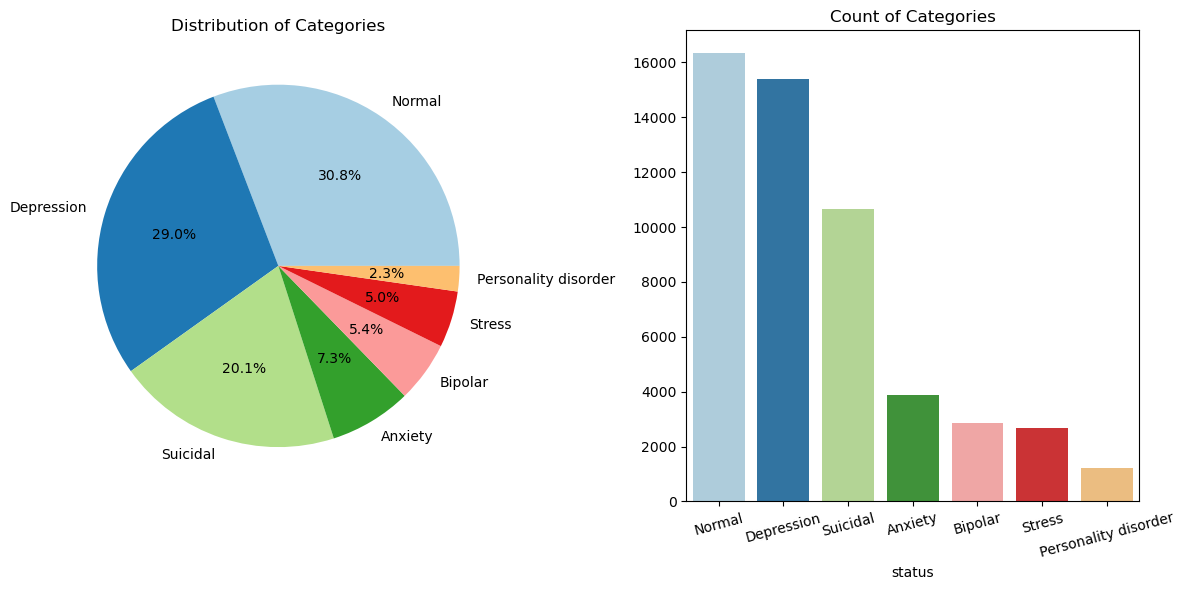

In [11]:
count = df['status'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("Paired", n_colors=len(count))
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
axs[0].set_title('Distribution of Categories')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1],  hue=count.index, palette=palette)
axs[1].set_title('Count of Categories')
axs[1].tick_params(axis='x', rotation=15)

# Adjust layout
plt.tight_layout();



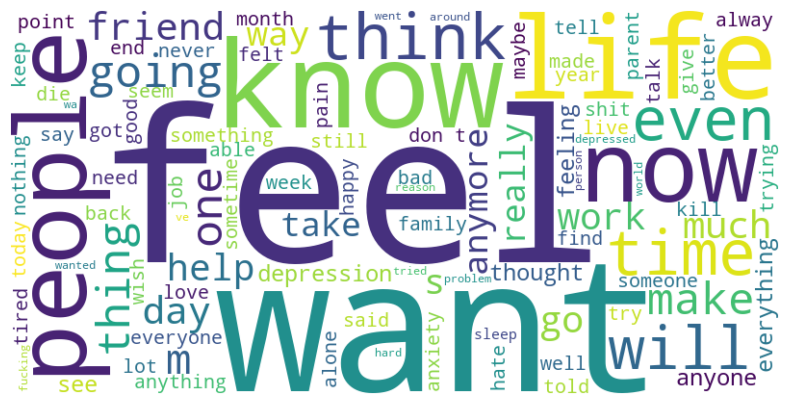

In [12]:
# Visualize word cloud
# Combine all the text in the 'statement' column into one large string
text_data = ' '.join(df['statement'].dropna())

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text_data)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

In [13]:
# Function to extract special characters and numbers
def extract_special_characters_and_numbers(text):
    if pd.isna(text):  # Handle NaN values
        return [], []
    text = str(text)  # Ensure text is a string
    special_characters = re.findall(r'[^a-zA-Z0-9\s]', text)  # Find non-alphanumeric characters
    numbers = re.findall(r'\d+', text)  # Find numeric values
    return special_characters, numbers


# Apply the function
df['special_characters'], df['numbers'] = zip(*df['statement'].apply(extract_special_characters_and_numbers))


# To count how many unique special characters and numbers there are in the whole DataFrame
all_special_chars = df['special_characters'].explode().value_counts()
all_numbers = df['numbers'].explode().value_counts()

print("Special characters in the dataset:")
print(all_special_chars)


Special characters in the dataset:
special_characters
.    316974
,    175888
'     47563
?     30999
’     26549
      ...  
😥         1
↑         1
🥱         1
🙈         1
⏳         1
Name: count, Length: 326, dtype: int64


# Data Preprocessing

In [3]:
df1 = df.copy()

# Converts non-string objects in the DataFrame to strings
df1 = convert_non_strings_to_strings(df1)

# Drop rows with missing values
df1 = df1.dropna()

# # Drop duplicated rows 
df1.drop_duplicates(inplace=True)

# Check if the data is well formated
is_valid = validate_dataset(df1)
is_valid

Dataset validation successful! The dataset is correctly formatted.


True

In [4]:
# New shape
print(f"The new shape of the data is: {df1.shape}")

The new shape of the data is: (51099, 2)


In [5]:
BASE_DIR = "../models"
data_path = os.path.join(BASE_DIR, "preprocessed_data.pkl")
label_encoder_path = os.path.join(BASE_DIR, "label_encoder.pkl")

# Check if the preprocessed data already exists
if os.path.exists(data_path) and os.path.exists(label_encoder_path):
    print("Loading preprocessed dataset and LabelEncoder...")
    
    # Load DataFrame
    df1 = pd.read_pickle(data_path)

    # Load LabelEncoder
    with open(label_encoder_path, "rb") as f:
        label_encoder = pickle.load(f)

else:
    print("Preprocessing data and saving...")

    # Apply functions to preprocess the data
    df1["processed_statement"] = df1["statement"].astype(str).apply(preprocess_text)

    # Compute Label Encoding
    label_encoder = LabelEncoder()
    df1["processed_status"] = label_encoder.fit_transform(df1["status"])

    # Save LabelEncoder
    with open(label_encoder_path, "wb") as f:
        pickle.dump(label_encoder, f)

    # Save the preprocessed dataset
    df1.to_pickle(data_path)  # Efficient storage

    print("Preprocessed dataset and LabelEncoder saved!")

# Retrieve class labels
class_labels = label_encoder.classes_


Loading preprocessed dataset and LabelEncoder...


In [6]:
BASE_DIR = "../models"
data_path = os.path.join(BASE_DIR, "dataset_splits.npz")
preprocessed_data_path = os.path.join(BASE_DIR, "preprocessed_data.pkl")
label_encoder_path = os.path.join(BASE_DIR, "label_encoder.pkl")

# Load preprocessed data if available
if os.path.exists(preprocessed_data_path) and os.path.exists(label_encoder_path):
    print("Loading precomputed preprocessed data...")

    # Load DataFrame
    df1 = pd.read_pickle(preprocessed_data_path)

    # Load LabelEncoder
    with open(label_encoder_path, "rb") as f:
        label_encoder = pickle.load(f)

    class_labels = label_encoder.classes_
else:
    print("Preprocessed data not found! Please run the preprocessing step first.")
    exit()  # Stop execution if preprocessed data is missing

# Load or split dataset
if os.path.exists(data_path):
    print("Loading precomputed dataset splits...\n")
    data = load_npz_file(data_path)
    X_train, X_val, X_test = data["X_train"], data["X_val"], data["X_test"]
    y_train_encoded, y_val_encoded, y_test_encoded = data["y_train"], data["y_val"], data["y_test"]

else:
    print("Splitting and saving dataset...")

    # Perform stratified splitting
    X_train, X_val, X_test, y_train_encoded, y_val_encoded, y_test_encoded = stratified_train_val_test_split(
        df1, text_column="processed_statement", label_column="processed_status", val_size=0.1, test_size=0.1
    )

    # Save dataset splits
    save_npz_file(data_path, 
                  X_train=X_train, X_val=X_val, X_test=X_test,
                  y_train=y_train_encoded, y_val=y_val_encoded, y_test=y_test_encoded)

    print("Dataset splits saved!\n")

# Print dataset shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train_encoded.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val_encoded.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test_encoded.shape}\n")
print(f"Class labels: {class_labels}")


Loading precomputed preprocessed data...
Loading precomputed dataset splits...

X_train shape: (40879,), y_train shape: (40879,)
X_val shape: (5110,), y_val shape: (5110,)
X_test shape: (5110,), y_test shape: (5110,)

Class labels: ['Anxiety' 'Bipolar' 'Depression' 'Normal' 'Personality disorder' 'Stress'
 'Suicidal']


Download the model here: [ https://code.google.com/archive/p/word2vec/](https://code.google.com/archive/p/word2vec/)

In [7]:
# Paths
BASE_DIR = "../models"
word2vec_path = os.path.join(BASE_DIR, "GoogleNews-vectors-negative300.bin")

In [ ]:
# Load the Word2Vec model
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Get the number of words (size of the vocabulary)
num_words = len(model.key_to_index)

print(f"Number of words in the Word2Vec model: {num_words}")

Number of words in the Word2Vec model: 3000000


In [9]:
# Test

MAX_NUM_WORDS = 75000
EMBEDDING_DIM = 50
MAX_SEQUENCE_LENGTH = 20

X_train_padded_sample, X_val_padded_sample, X_test_padded_sample, tokenizer_sample, embedding_matrix_sample = process_data_for_model_input(
    word2vec_path, X_train[:3], X_val[:2], X_test[:1], MAX_NUM_WORDS=MAX_NUM_WORDS, EMBEDDING_DIM=EMBEDDING_DIM, MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH
)


print("\n X_train_sample \n ", X_train[:3], X_train[:3].shape)
print("\n X_train_padded_sample \n ", X_train_padded_sample, X_train_padded_sample.shape)
print("\n X_val_padded_sample \n ", X_val[:2], X_val[:2].shape)
print("\n X_val_padded_sample \n ", X_val_padded_sample, X_val_padded_sample.shape)
print("\n X_test_padded_sample \n ", X_test[:1], X_test[:1].shape)
print("\n X_test_padded_sample \n ", X_test_padded_sample, X_test_padded_sample.shape)
print("\n embedding_matrix_sample \n ", embedding_matrix_sample, embedding_matrix_sample.shape)

Computing Word2Vec embeddings...
Word2Vec embeddings saved!
Computing tokenizer...
Tokenizer saved!
Computing embedding matrix...
Computing padded sequences...

Tokenizer vocab size: 160

Data processing complete.

 X_train_sample 
  ['want diana f look great'
 'find affect memori  realiz  whenev make eye contact feel like awk moment help tip promot eye contact '
 'holyjaw middl night commit instal window boot camp alreadi issu'] (3,)

 X_train_padded_sample 
  [[12 35 36 37 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [39 40 13 41 42 14 15 16  2  4 43 44  5 45 46 15 16  0  0  0]
 [47 17 48 49 50 51 52 53 18  6  0  0  0  0  0  0  0  0  0  0]] (3, 20)

 X_val_padded_sample 
  ['pleas help  someon sever mess mind smoke heavi pot young age one thousand, two hundred and thirteen even though alway bug  fast forward  twenty-seven job  still live parent  problem solv hold convers anyon  friend get marri  alon sever anxieti  want end  know  im six month sober know perman damag brain  plea

In [10]:
print("Tokenizer word index:", tokenizer_sample.word_index)
print("Tokenizer vocab size:", len(tokenizer_sample.word_index)+1)

Tokenizer word index: {'<OOV>': 1, 'feel': 2, 'start': 3, 'like': 4, 'help': 5, 'issu': 6, 'get': 7, 'know': 8, 'mom': 9, 'shit': 10, 'upset': 11, 'want': 12, 'memori': 13, 'make': 14, 'eye': 15, 'contact': 16, 'middl': 17, 'alreadi': 18, 'pleas': 19, 'sever': 20, 'even': 21, 'alway': 22, 'anyon': 23, 'come': 24, 'past': 25, 'last': 26, 'week': 27, 'bc': 28, 'away': 29, 'year': 30, 'due': 31, 'life': 32, 'break': 33, 'write': 34, 'diana': 35, 'f': 36, 'look': 37, 'great': 38, 'find': 39, 'affect': 40, 'realiz': 41, 'whenev': 42, 'awk': 43, 'moment': 44, 'tip': 45, 'promot': 46, 'holyjaw': 47, 'night': 48, 'commit': 49, 'instal': 50, 'window': 51, 'boot': 52, 'camp': 53, 'someon': 54, 'mess': 55, 'mind': 56, 'smoke': 57, 'heavi': 58, 'pot': 59, 'young': 60, 'age': 61, 'one': 62, 'thousand': 63, 'two': 64, 'hundred': 65, 'and': 66, 'thirteen': 67, 'though': 68, 'bug': 69, 'fast': 70, 'forward': 71, 'twenty': 72, 'seven': 73, 'job': 74, 'still': 75, 'live': 76, 'parent': 77, 'problem': 78

In [39]:
# Gat data ready for model

MAX_NUM_WORDS = 100000
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 100

X_train_padded, X_val_padded, X_test_padded, tokenizer, embedding_matrix =  process_data_for_model_input(
    word2vec_path, X_train, X_val, X_test, MAX_NUM_WORDS=MAX_NUM_WORDS, EMBEDDING_DIM=EMBEDDING_DIM, MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH
)

Computing Word2Vec embeddings...
Word2Vec embeddings saved!
Computing tokenizer...
Tokenizer saved!
Computing embedding matrix...
Computing padded sequences...

Tokenizer vocab size: 56566

Data processing complete.


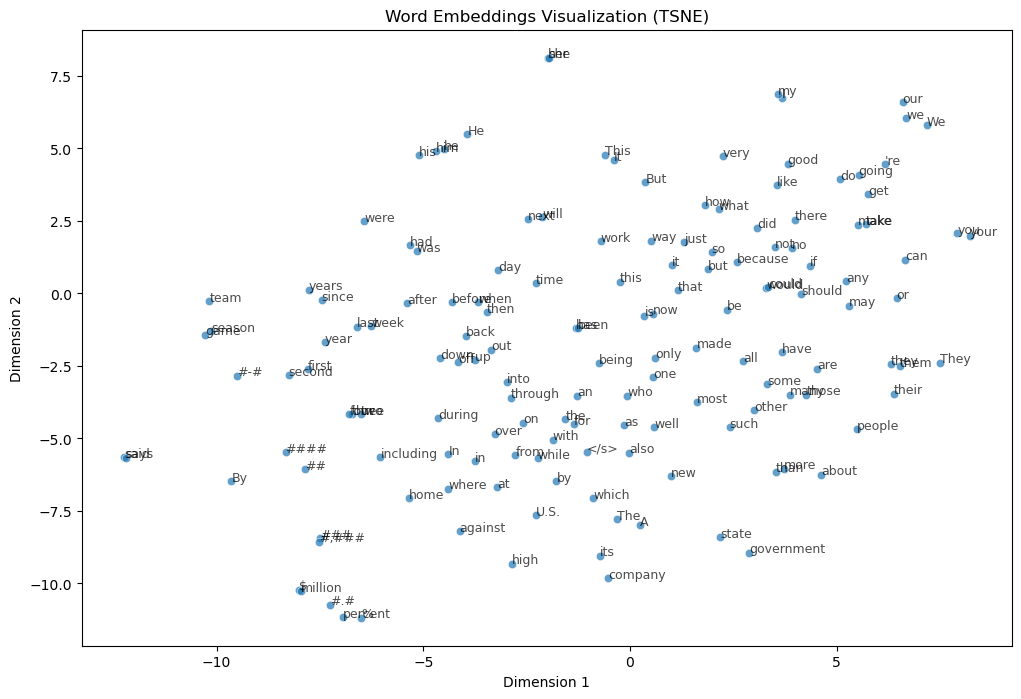

In [40]:
BASE_DIR = "../models"
word2vec_reduced_path = os.path.join(BASE_DIR, "word2vec_reduced.pkl")

# Load the reduced embeddings
word2vec_reduced = load_pickle(word2vec_reduced_path)  

# Plot the embeddings
plot_embeddings(word2vec_reduced, num_words=150, method="tsne")


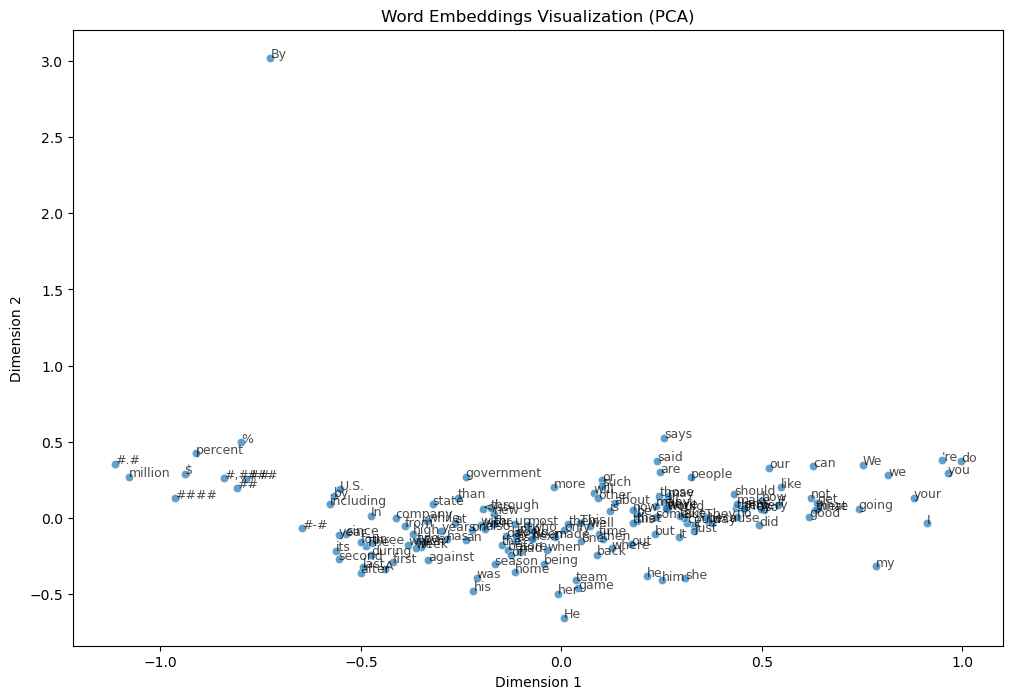

In [41]:
# Plot the embeddings
plot_embeddings(word2vec_reduced, num_words=150, method="pca")

# Data Modeling

In [14]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

import gensim
from sklearn.decomposition import TruncatedSVD
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional, LSTM, GRU, BatchNormalization, Dense, LayerNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report

In [15]:
def rule_of_thumb_1(data, alpha=5) -> int:
    if alpha < 2 or alpha > 10:
        raise ValueError("Alpha must be between 2 and 10.")
    
    # Number of samples (N_s), number of input neurons (N_i), number of output neurons (N_o)
    N_s, N_i = data.shape 
    N_o = len(class_labels)  
    
    # Calculate N_h 
    N_h = int(N_s / (alpha * (N_i + N_o)))
    
    return N_h

def rule_of_thumb_2(data) -> int:
    # Number of samples (N_s), number of input neurons (N_i), number of output neurons (N_o)
    N_s, N_i = data.shape 
    N_o = len(class_labels) 
    
    hidden_neurons = int((2 / 3) * N_i + N_o)
    
    return hidden_neurons



# Calculate the number of hidden units: N_h 
ALPHA = 2
TRAIN_DATA = X_train_padded
hidden_neurons = rule_of_thumb_1(TRAIN_DATA, alpha=ALPHA)
# hidden_neurons = rule_of_thumb_2(TRAIN_DATA)
print(f"Suggested number of hidden units (N_h): {hidden_neurons}")

Suggested number of hidden units (N_h): 191


### Bi-LSTM Model

In [124]:
# # Define the model

# import tensorflow as tf

# bilstm_model = tf.keras.models.Sequential([
#     Embedding(input_dim=len(tokenizer.word_index) + 1,
#               output_dim=embedding_dim,
#               weights=[embedding_matrix],  # Pretrained weights
#               trainable=True),  # trainable=False to fine-tune
    
#     Bidirectional(LSTM(128)),
#     LayerNormalization(),
#     Dropout(0.4),
#     Dense(64, activation='relu'),
#     Dropout(0.4),
#     Dense(len(class_labels), activation='softmax')
# ])

# # Compile the model
# bilstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Print model summary
# bilstm_model.summary()


In [71]:
# Define the model
bilstm_model = Sequential()

# Add embedding layer with pretrained embeddings
bilstm_model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                           output_dim=EMBEDDING_DIM,
                           weights=[embedding_matrix],  # Pretrained weights
                           trainable=True))  # trainable=True to fine-tune

# bilstm_model.add(Bidirectional(LSTM(128, return_sequences=False)))
bilstm_model.add(Bidirectional(LSTM(64, return_sequences=False)))
# bilstm_model.add(LayerNormalization())
# bilstm_model.add(BatchNormalization())
bilstm_model.add(Dropout(0.4))
bilstm_model.add(Dense(32))
bilstm_model.add(Dropout(0.4))

# Add the output layer with 7 units for 7 labels and softmax activation
bilstm_model.add(Dense(len(class_labels), activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=1e-03)
bilstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
bilstm_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │     5,656,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,656,600 (21.58 MB)

 Trainable params: 5,656,600 (21.58 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:
# # Set up TensorBoard callback
# log_dir = "logs/fit"
# tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# EarlyStopping to avoid overfitting 
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Set up ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-6)

# Train the model with ReduceLROnPlateau
history_bilstm = bilstm_model.fit(X_train_padded, y_train_encoded, 
                                  epochs=10, batch_size=32, 
                                  validation_data=(X_val_padded, y_val_encoded),
                                  callbacks=[early_stopping, reduce_lr],
                                  shuffle=True)


Epoch 1/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 140s 106ms/step - accuracy: 0.5677 - loss: 1.1636 - val_accuracy: 0.7358 - val_loss: 0.7176 - learning_rate: 0.0010
Epoch 2/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 138s 108ms/step - accuracy: 0.7673 - loss: 0.6556 - val_accuracy: 0.7358 - val_loss: 0.6995 - learning_rate: 0.0010
Epoch 3/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 141s 110ms/step - accuracy: 0.8198 - loss: 0.5133 - val_accuracy: 0.7472 - val_loss: 0.6775 - learning_rate: 0.0010
Epoch 4/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 140s 110ms/step - accuracy: 0.8618 - loss: 0.3966 - val_accuracy: 0.7386 - val_loss: 0.7306 - learning_rate: 0.0010
Epoch 5/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 140s 110ms/step - accuracy: 0.9053 - loss: 0.2841 - val_accuracy: 0.7421 - val_loss: 0.8478 - learning_rate: 2.0000e-04
Epoch 6/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 142s 111ms/step - accuracy: 0.9198 - loss: 0.2353 - val_accuracy: 0.7376 - val_loss: 0.8812 - learning_rate: 4.0000e-05
Epoch 7/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 14

In [25]:
# %load_ext tensorboard

In [26]:
# %tensorboard --logdir=logs/fit

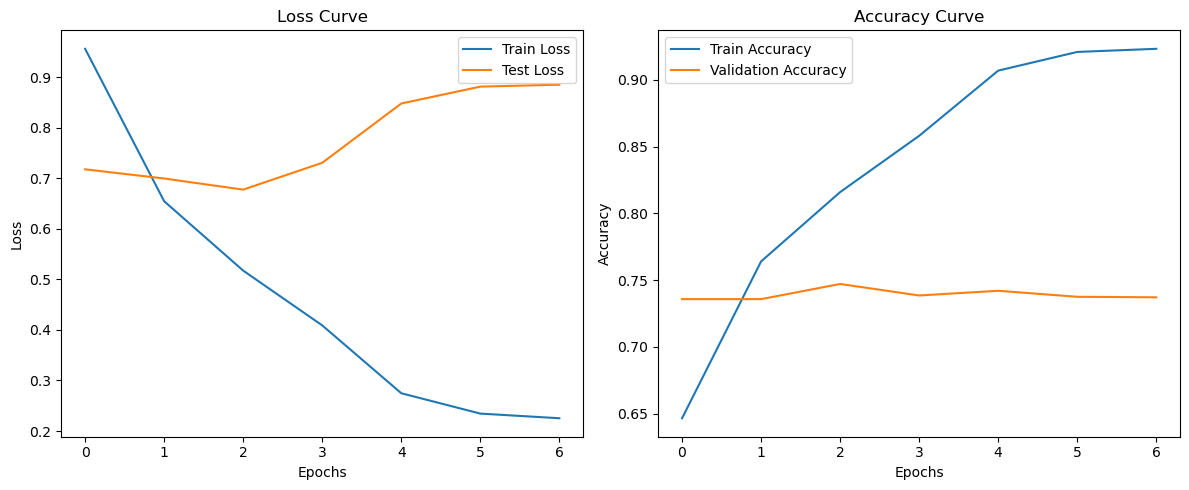

In [73]:
# Plot loss and accuracy

plot_loss(history_bilstm)

In [74]:
# Evaluate on the validation set
val_loss, val_acc = bilstm_model.evaluate(X_val_padded, y_val_encoded)

print(f"\nValidation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7517 - loss: 0.6726

Validation Accuracy: 0.7472
Validation Loss: 0.6775


In [75]:
# Predictions 
y_pred_encoded = bilstm_model.predict(X_val_padded)
y_pred_encoded = np.argmax(y_pred_encoded, axis=1)

y_val_original = label_encoder.inverse_transform(y_val_encoded)
y_pred_original = label_encoder.inverse_transform(y_pred_encoded)

report = classification_report(y_val_original, y_pred_original, target_names=label_encoder.classes_)


print("\n",report)

160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step

                       precision    recall  f1-score   support

             Anxiety       0.81      0.73      0.77       362
             Bipolar       0.76      0.75      0.75       251
          Depression       0.67      0.71      0.69      1509
              Normal       0.90      0.91      0.91      1604
Personality disorder       0.69      0.33      0.44        89
              Stress       0.45      0.55      0.49       230
            Suicidal       0.67      0.63      0.65      1065

            accuracy                           0.75      5110
           macro avg       0.71      0.66      0.67      5110
        weighted avg       0.75      0.75      0.75      5110



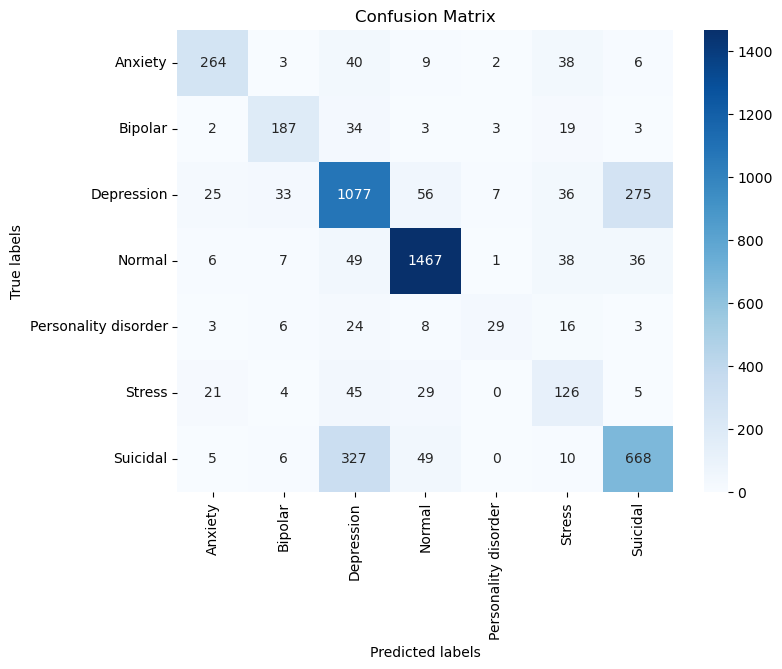

In [76]:
# Plot confusion matrix

plot_confmat(y_val_original, y_pred_original, label_encoder=label_encoder)

In [57]:
# Save the model
bilstm_model.save("../models/bilstm_model_v1.keras")

### Test set evaluation

In [58]:
# Evaluate on test set
test_loss, test_acc = bilstm_model.evaluate(X_test_padded, y_test_encoded)

print(f"\nTest Accuracy Bi-LSTM: {test_loss:.4f}")
print(f"Test Loss Bi-LSTM: {test_acc:.4f}")

160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7712 - loss: 0.6200

Test Accuracy Bi-LSTM: 0.6239
Test Loss Bi-LSTM: 0.7701


In [59]:
# Predictions 
y_pred_encoded = bilstm_model.predict(X_test_padded)
y_pred_encoded = np.argmax(y_pred_encoded, axis=1)

y_test_original = label_encoder.inverse_transform(y_test_encoded)
y_pred_original = label_encoder.inverse_transform(y_pred_encoded)

report = classification_report(y_test_original, y_pred_original, target_names=label_encoder.classes_)

print("\n",report)

160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step

                       precision    recall  f1-score   support

             Anxiety       0.80      0.77      0.79       363
             Bipolar       0.84      0.74      0.79       250
          Depression       0.69      0.75      0.72      1510
              Normal       0.92      0.92      0.92      1604
Personality disorder       0.69      0.44      0.54        90
              Stress       0.52      0.51      0.52       229
            Suicidal       0.70      0.66      0.68      1064

            accuracy                           0.77      5110
           macro avg       0.74      0.69      0.71      5110
        weighted avg       0.77      0.77      0.77      5110



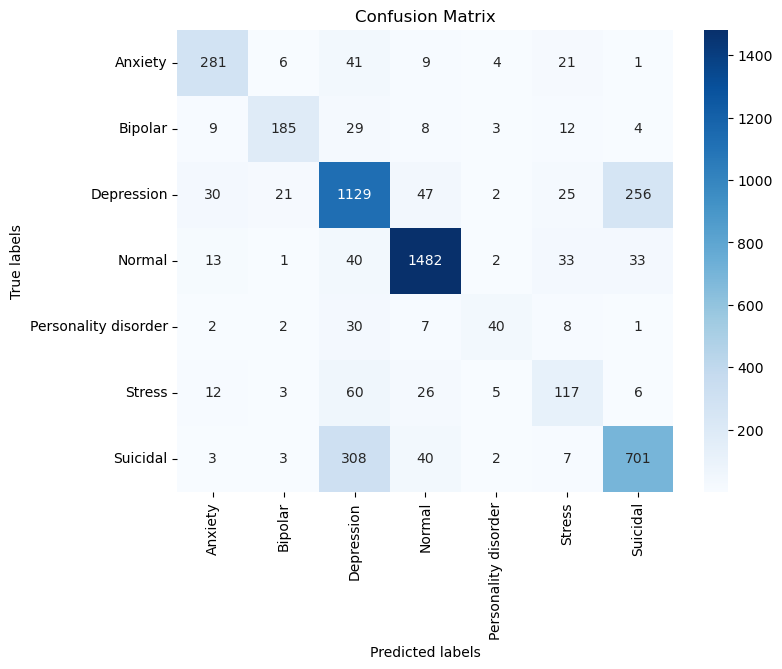

In [60]:
# Plot confusion matrix

plot_confmat(y_test_original, y_pred_original, label_encoder=label_encoder)

# Inference

In [61]:
from tensorflow.keras.models import load_model

import sys
sys.path.append("..")
from ml_helper.inference import predict_sentiment

In [62]:
# Paths to saved models
model_path = "../models/bilstm_model_v1.keras"
tokenizer_path = "../models/tokenizer.pkl"

# Load the trained model
bilstm_model = load_model(model_path)

# Load the tokenizer
tokenizer = load_pickle(tokenizer_path)

In [63]:
print(class_labels)

['Anxiety' 'Bipolar' 'Depression' 'Normal' 'Personality disorder' 'Stress'
 'Suicidal']


In [64]:
# User query
sample_text = "I had a pretty good day at work, nothing too exciting but nothing bad either."

# Make a prediction
predicted_sentiment = predict_sentiment(bilstm_model, tokenizer, sample_text, max_length=100, class_labels=class_labels)

print()
print(sample_text)
print(f"Predicted Sentiment: {predicted_sentiment}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step

I had a pretty good day at work, nothing too exciting but nothing bad either.
Predicted Sentiment: Normal


In [65]:
# User query
sample_text = "There's so much going on right now, I feel like I can't keep up."

# Make a prediction
predicted_sentiment = predict_sentiment(bilstm_model, tokenizer, sample_text, max_length=100, class_labels=class_labels)

print()
print(sample_text)
print(f"Predicted Sentiment: {predicted_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

There's so much going on right now, I feel like I can't keep up.
Predicted Sentiment: Normal


In [66]:
# User query
sample_text = "I struggle with extreme mood swings that confuse the people around me."

# Make a prediction
predicted_sentiment = predict_sentiment(bilstm_model, tokenizer, sample_text, max_length=100, class_labels=class_labels)

print()
print(sample_text)
print(f"Predicted Sentiment: {predicted_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

I struggle with extreme mood swings that confuse the people around me.
Predicted Sentiment: Normal


In [67]:
# User query
sample_text = "I have so many deadlines coming up, and I don't know how I'm going to finish everything on time!"

# Make a prediction
predicted_sentiment = predict_sentiment(bilstm_model, tokenizer, sample_text, max_length=100, class_labels=class_labels)

print()
print(sample_text)
print(f"Predicted Sentiment: {predicted_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

I have so many deadlines coming up, and I don't know how I'm going to finish everything on time!
Predicted Sentiment: Normal


In [68]:
# User query
sample_text = "Without alcohol, self-harm is my only escape. I've set a date to end my life but might do it sooner. I don't want to live anymore."

# Make a prediction
predicted_sentiment = predict_sentiment(bilstm_model, tokenizer, sample_text, max_length=100, class_labels=class_labels)

print()
print(sample_text)
print(f"Predicted Sentiment: {predicted_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

Without alcohol, self-harm is my only escape. I've set a date to end my life but might do it sooner. I don't want to live anymore.
Predicted Sentiment: Suicidal


In [69]:
# User query
sample_text = "Any experiences with Abilify? I just started taking it this week and would love to hear your thoughts!"

# Make a prediction
predicted_sentiment = predict_sentiment(bilstm_model, tokenizer, sample_text, max_length=100, class_labels=class_labels)

print()
print(sample_text)
print(f"Predicted Sentiment: {predicted_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

Any experiences with Abilify? I just started taking it this week and would love to hear your thoughts!
Predicted Sentiment: Normal


In [70]:
# User query
sample_text = "Does anyone else feel like they had to learn social dynamics from external sources instead of just instinctively knowing them?"

# Make a prediction
predicted_sentiment = predict_sentiment(bilstm_model, tokenizer, sample_text, max_length=100, class_labels=class_labels)

print()
print(sample_text)
print(f"Predicted Sentiment: {predicted_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

Does anyone else feel like they had to learn social dynamics from external sources instead of just instinctively knowing them?
Predicted Sentiment: Normal
